점점 미쳐가는 중

###사유

7일의 데이터를 사용해서 2일의 데이터를 예측해야한다ㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏㅏ


###문제

많은 것이 문제, 무엇보다 문제는 **input과 output의 모양이 달라서** 도통 되먹지를 않는다.

일단 7일치를 2일치로 퉁치는 것이 문제임

두 번째 문제는 변수 6개로 1개 예측하는 것이 문제임

합치면, **7일치의 변수 6개로, 2일치 정답변수 1개를 예측하는 문제**가 되어서 난장판ㄴㄴㄴㄴㄴ

문제2, 원래 LSTM은 이미지 처리, 텍스트 처리에 쓰는 경우가 많아서 일단 이런 회귀는 다른 모델이 더 좋다. 애초에 들어가서 구동이 안됨


### 방안

자연어(NLP) 해석 신경망을 훔쳐왔다.

**한국어 - 영어 해석은 input과 output shape(글자의 숫자, 주어/동사/목적어)이 달라도 돌아간다.**

그런고로 7일치 6개의 변수 > 2일치 1개의 정답도 대충 되지 않을까 기대함.

안되면 환불손절

In [92]:
from google.colab import drive
!pip install import_ipynb
import import_ipynb
# 구글 드라이브에 자료 전처리 함수, raw_data 올려놓았다.
# 일단 불러오기
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from pandas import DataFrame
from pandas import concat
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [94]:
raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')

In [95]:
# !cp가 뭔지는 모르지만, 이렇게 해야 함수를 불러올 수 있다고 함.
# lstm_defs.py에 전처리 함수를 저장해 놓았으므로 얘를 MJ로 불러온다.
!cp /content/drive/MyDrive/Jupyter/unlimited_power/working__/LSTM_functions.ipynb .
import LSTM_functions as MJ

# 불러온 데이터를 MJ.py에 미리 정의해 둔 data_loadder 함수에 때려 넣으면
# 자동으로 train_X, train_y, test_X, test_y 4가지가 선언된다.
train_set, test_set = MJ.preprocessing(raw_data)

Final Shape is :
torch.Size([100, 336, 6])
torch.Size([100, 96])


In [96]:
### parameters

## 학습에 사용할 변수의 개수 5개 + target 변수(7일간)
n_features = 6

In [97]:
if torch.cuda.is_available() == True:
  print("사용 가능한 GPU 개수 : ", torch.cuda.device_count())
  print("GPU Index(위치) : ", torch.cuda.current_device())
  print("GPU 이름 : ", torch.cuda.get_device_name(0))
  torch.cuda.device(0)

사용 가능한 GPU 개수 :  1
GPU Index(위치) :  0
GPU 이름 :  Tesla P100-PCIE-16GB


In [98]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()

        self.device = torch.cuda.current_device()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers).cuda()
        self.hidden = None

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device))

    def forward(self, inputs):
        # Push through RNN layer (the ouput is irrelevant)
        # _, self.hidden = self.lstm(inputs.cuda(), self.hidden)
        _, self.hidden = self.lstm(inputs, self.hidden)
        return self.hidden

In [99]:
# class Decoder(nn.Module):

#     def __init__(self, hidden_dim, num_layers=3):
#         super(Decoder, self).__init__()
#         # input_size=1 since the output are single values
#         self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)
#         self.out = nn.Linear(hidden_dim, 1)

#     def forward(self, outputs, hidden): #, criterion):
#         batch_size, num_steps = outputs.shape
#         # Create initial start value/token
#         input = torch.tensor([[0.0]] * batch_size, dtype=torch.float)
#         # Convert (batch_size, output_size) to (seq_len, batch_size, output_size)
#         input = input.unsqueeze(0)

#         loss = 0
#         for i in range(num_steps):
#             # Push current input through LSTM: (seq_len=1, batch_size, input_size=1)
#             output, hidden = self.lstm(input, hidden)
#             # Push the output of last step through linear layer; returns (batch_size, 1)
#             output = self.out(output[-1])
#             # Generate input for next step by adding seq_len dimension (see above)
#             input = output.unsqueeze(0)
#             # Compute loss between predicted value and true value
#             loss += tilted_loss(0.5, output, outputs[:, i])
#         return loss

In [100]:
class Decoder(nn.Module):

    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # input_size=1 since the output are single values
        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers).cuda()
        self.out = nn.Linear(hidden_dim, 1).cuda()

    def forward(self, outputs, hidden, criterion):
        batch_size, num_steps = outputs.shape
        # Create initial start value/token
        input = torch.tensor([[0.0]] * batch_size, dtype=torch.float).cuda()
        # Convert (batch_size, output_size) to (seq_len, batch_size, output_size)
        input = input.unsqueeze(0)

        loss = 0
        for i in range(num_steps):
            # Push current input through LSTM: (seq_len=1, batch_size, input_size=1)
            output, hidden = self.lstm(input, hidden)
            # Push the output of last step through linear layer; returns (batch_size, 1)
            output = self.out(output[-1])
            # Generate input for next step by adding seq_len dimension (see above)
            input = output.unsqueeze(0)
            # Compute loss between predicted value and true value
            loss += criterion(output, outputs[:, i])
        return loss

In [101]:
# 손실함수
# Quantile 별로 구해야하니까, q 값에 quantile을 넣어야한다.

def tilted_loss(q,y,f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e), axis=-1)

In [103]:
epoch = 200
loss_list = []

encoder = Encoder(n_features, 64).cuda()
decoder = Decoder(64).cuda()
# Create optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)
criterion = nn.MSELoss()

for i in range(epoch):
    for i, (train, train_target) in enumerate(train_set):
          # 5 is the number of features of your data points
            
      # Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
      inputs = train
      inputs = inputs.transpose(1,0).float().cuda()

      # 2 sequences (to match the batch size) of length 6 (for the 6h into the future)
      outputs = train_target.float().cuda()

      # Do one complete forward & backward pass
      #
      # Zero gradients of both optimizers
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()
      # Reset hidden state of encoder for current batch
      encoder.hidden = encoder.init_hidden(inputs.shape[1])

      # Do forward pass through encoder
      hidden = encoder(inputs)
      # Do forward pass through decoder (decoder gets hidden state from encoder)
      #outputs = train_target.float32
      loss = decoder(outputs, hidden, criterion)
      # Backpropagation
      loss.backward()
      # Update parameters
      encoder_optimizer.step()
      decoder_optimizer.step()
    loss_list.append(loss.item())
    print("Loss:", loss.item())
    print(i)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([90])) that is different to the input size (torch.Size([90, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 67401.640625
364
Loss: 61951.1484375
364
Loss: 61107.7265625
364
Loss: 59968.515625
364
Loss: 59741.81640625
364
Loss: 65789.6171875
364
Loss: 63707.7109375
364
Loss: 64718.953125
364
Loss: 64865.01953125
364
Loss: 68217.796875
364
Loss: 60022.64453125
364
Loss: 64462.484375
364
Loss: 67374.40625
364
Loss: 63646.609375
364
Loss: 63595.5390625
364
Loss: 59401.35546875
364
Loss: 65434.2109375
364
Loss: 63308.18359375
364
Loss: 67551.0703125
364
Loss: 64136.67578125
364
Loss: 59601.53125
364
Loss: 59350.8515625
364
Loss: 58674.046875
364
Loss: 62512.9609375
364
Loss: 58389.68359375
364
Loss: 62865.9609375
364
Loss: 63171.9296875
364
Loss: 66538.234375
364
Loss: 64110.3671875
364
Loss: 63996.828125
364
Loss: 66130.46875
364
Loss: 60816.96875
364
Loss: 62612.49609375
364
Loss: 63284.1953125
364
Loss: 64278.078125
364
Loss: 69672.8515625
364
Loss: 56754.359375
364
Loss: 64038.3984375
364
Loss: 66102.4453125
364
Loss: 60693.1171875
364
Loss: 62479.30859375
364
Loss: 67442.1875
364
Loss:

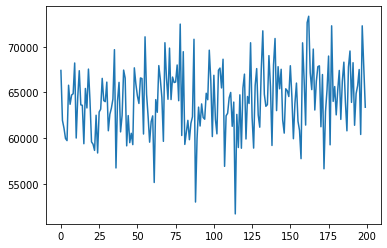

In [104]:
plt.plot(loss_list)
plt.show()

In [ ]:
# epoch = 2

# for i in range(epoch):
#     for i, (train, train_target) in enumerate(train_set):
#           # 5 is the number of features of your data points
      
#       encoder = Encoder(n_features, 64)
#       decoder = Decoder(64)
#       # Create optimizers for encoder and decoder
#       encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
#       decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)
#       #criterion = nn.MSELoss()

      
#       # Convert (batch_size, seq_len, input_size) to (seq_len, batch_size, input_size)
#       inputs = train
#       inputs = inputs.transpose(1,0) .float()

#       # 2 sequences (to match the batch size) of length 6 (for the 6h into the future)
#       outputs = train_target

#       # Do one complete forward & backward pass
#       #
#       # Zero gradients of both optimizers
#       encoder_optimizer.zero_grad()
#       decoder_optimizer.zero_grad()
#       # Reset hidden state of encoder for current batch
#       encoder.hidden = encoder.init_hidden(inputs.shape[1])
#       # Do forward pass through encoder
#       hidden = encoder(inputs)
#       # Do forward pass through decoder (decoder gets hidden state from encoder)
#       loss = decoder(outputs, hidden)
#       # Backpropagation
#       loss.sum().backward()
#       # Update parameters
#       encoder_optimizer.step()
#       decoder_optimizer.step()
#       print("Loss:", loss.sum())